# 模拟一维海森堡链的自旋动力学

<em> Copyright (c) 2021 Institute for Quantum Computing, Baidu Inc. All Rights Reserved. </em>

## 概述

模拟一个量子系统的性质，是量子计算机的重要应用之一。一般来说，分析一个量子系统的性质需要先写出其哈密顿量 $H$，而对于不同尺度下的物理系统而言，这个哈密顿量往往具有不同的形式。以量子化学为例，一个分子的性质主要由电子-电子之间的库伦相互作用而决定，因此其哈密顿量中的每一项都是由作用在电子波函数上的费米子算符写成的。而量子计算机的基本组成单元量子比特（qubit）以及常用的泡利算符，对应着物理上的自旋和自旋算符。因此，若想在量子计算机上对分子性质进行模拟，则往往需要进行从费米子算符到泡利算符的转换，例如 Jordan-Wigner 变换、Bravyi-Kitaev 变换等等。这也就使得量子计算机需要消耗更多的资源来进行分子哈密顿量的模拟。因此，对于近期的量子设备而言，最有可能率先实现的便是对量子自旋系统的量子模拟——因为这些系统的哈密顿量可以直接写成泡利算符的形式。

在本教程中，我们选取了一个比较经典的量子自旋模型——海森堡模型，并将展示如何利用 Paddle Quantum 来进行一维海森堡自旋链的时间演化模拟。我们主要会使用 `construct_trotter_circuit()` 函数来搭建基于 product formula 的模拟时间演化电路，在先前的教程 [利用 Product Formula 模拟时间演化](./HamiltonianSimulation_CN.ipynb) 中有对该方法较为详细的理论介绍，在本教程中也会有较为简略的回顾。本教程将主要着眼于实际的应用，可以分为两个部分：
- 海森堡模型的物理背景以及利用 Paddle Quantum 对其时间演化进行模拟 
- 基于随机置换来搭建自定义时间演化电路

---
在进一步介绍本教程中涉及的物理背景之前，我们先来回顾一下利用量子电路来模拟时间演化的基本思想，对这部分内容已经比较熟悉的读者可以直接跳至 **海森堡自旋链与其动力学模拟** 继续阅读。

### 利用 Suzuki product formula 模拟时间演化

让我们先回顾一下使用 Suzuki product formula 来模拟时间演化的基本思想：对于一个被不含时的哈密顿量 $H = \sum_k^L h_k$ 描述的量子系统，其时间演化算符可以写为

$$
U(t) = e^{-iHt},
\tag{1}
$$

该算符可以被进一步拆分为 $r$ 份，即

$$
e^{-iHt} = \left( e^{-iH \tau} \right)^r, ~\tau=\frac{t}{r}.
\tag{2}
$$

对于每一个 $e^{-iH \tau}$ 算符而言，其 Suzuki 分解为

$$
\begin{aligned}
S_1(\tau) &= \prod_{k=0}^L \exp ( -i h_k \tau),
\\
S_2(\tau) &= \prod_{k=0}^L \exp ( -i h_k \frac{\tau}{2})\prod_{k=L}^0 \exp ( -i h_k \frac{\tau}{2}),
\\
S_{2k+2}(\tau) &= [S_{2k}(p_k\tau)]^2S_{2k}\left( (1-4p_k)\tau\right)[S_{2k}(p_k\tau)]^2.
\end{aligned}
\tag{3}
$$

回到完整的时间演化算符 $U(t)$，利用第 $k$ 阶的 Suzuki 分解，它可以被写为

$$
U(t) = e^{-iHt} = \left( S_{k}\left(\frac{t}{r}\right) \right)^r.
\tag{4}
$$

这种模拟时间演化的方法被称为 Suzuki product formula，它可以有效地模拟时间演化过程至任意精度 [1]。在另一份教程 [利用 Product Formula 模拟时间演化](./HamiltonianSimulation_CN.ipynb) 中，我们展示了其误差上界的计算过程，感兴趣的读者可以前往阅读。

---

## 海森堡模型与其动力学模拟

海森堡（Heisenberg）模型，是量子磁性以及量子多体物理研究中十分重要的一个模型。它的哈密顿量为

$$
H = \sum_{\langle i, j\rangle} 
\left( J_x S^x_{i} S^x_{j} + J_y S^y_{i} S^y_{j} + J_z S^z_{i} S^z_{j} \right)
+
\sum_{i} h_z S^z_i, 
\tag{5}
$$

其中 $\langle i, j\rangle$ 取决于具体的格点几何结构，$J_x, J_y, J_z$ 分别为 $xyz$ 三个方向上的自旋耦合强度，$h_z$ 是 $z$ 方向上的外加磁场。若取 $J_z = 0$，(5) 式也可以用来描述 XY 模型的哈密顿量；取 $J_x = J_y = 0$，(5) 式则可以用来描述伊辛模型（Ising model）的哈密顿量。注意在这里，我们使用了量子多体物理里面比较常用的多体自旋算符 $S^x_i, S^y_i, S^z_i$，它是一个作用在多体波函数上的算符。
对于自旋-1/2 系统而言，多体自旋算符可以被简单地写为泡利算符的张量积形式（省略一个 $\hbar/2$ 的系数）

$$
S^P_{i} = \left ( \otimes_{j=0}^{i-1} I \right ) \otimes \sigma_{P} \otimes \left ( \otimes_{j=i+1}^{L} I \right ),
P \in \{ x, y, z \},
\tag{6}
$$

其中 $\sigma_{P}$ 是泡利算符，我们也经常用 $XYZ$ 算符来表示它们。需要说明的是，海森堡模型并不是一个假想模型：从描述电子在格点系统上运动的赫巴德模型（Hubbard model）出发，在一定的极限条件下，电子会被固定在格点上并形成半满填充。此时，描述电子的赫巴德模型就退化为了描述自旋的海森堡模型，而 (5) 式中的自旋-自旋相互作用则是电子-电子之间的相互作用在这个极限下的一种有效交换相互作用 [2]。尽管做了许多的近似，但是海森堡模型依然成功地预言了许多实际材料在低温下的性质 [3]。比如读者可能在高中课本上就学习过的 $\rm Cu(NO_3)_2 \cdot 2.5 H_2 O$ 二点五水合硝酸铜在 $\sim 3K$ 的低温下的行为就可以被自旋-1/2 一维交错海森堡链所描述 [4]。

取决于其具体的格点结构，海森堡模型上可以展示出丰富的量子现象。一维海森堡链可以被用来描述铁磁性与反铁磁性，对称性破缺以及无能隙激发。在二维阻挫格点系统上，海森堡模型可以被用来描述量子自旋液体态-这是一种包含了长程纠缠的新奇量子物态 [5]。若考虑一个外加的无序磁场时，海森堡模型还可以用来研究多体局域化现象（many-body localization, MBL），这是一种违反了热化假说的奇特现象，指的是一个量子多体系统经过了无穷长的时间演化后也不会热化，依然保留着其初态有关的信息 [6]。

模拟海森堡模型的时间演化过程，也被称为动力学模拟，可以帮助人们探索量子系统非平衡态相关的性质，从而用来寻找新奇的量子物相：例如前文提到的多体局域相，又或者更加有趣的时间晶体相 [7]。除了理论，动力学模拟对于实际的物理实验也有着重要的意义。这是因为自旋关联函数（也通常被称为动力学结构因子）直接决定了散射实验中的截面，或者是核磁共振实验的结果 [3]，该函数则是由含时的自旋算符 $\langle S(t) S(0) \rangle$ 的积分决定的。因此，通过计算不同理论模型的动力学演化，人们可以进一步对真实材料中的物理模型进行分析。

### 利用 Paddle Quantum 实现海森堡链的动力学模拟

下面，我们则会通过一个实际的例子：链长为 5 的含有无序外磁场的海森堡链，来展示如何在 Paddle Quantum 中搭建其时间演化电路。首先，我们引入相关的包。

In [1]:
import numpy as np
import scipy
from scipy import linalg
import matplotlib.pyplot as plt
from paddle_quantum.circuit import UAnsatz
from paddle_quantum.utils import SpinOps, Hamiltonian, gate_fidelity
from paddle_quantum.trotter import construct_trotter_circuit, get_1d_heisenberg_hamiltonian

接下来，我们利用 `get_1d_heisenberg_hamiltonian()` 函数来得到一个一维海森堡链的哈密顿量： 

In [2]:
h = get_1d_heisenberg_hamiltonian(length=5, j_x=1, j_y=1, j_z=2, h_z=2 * np.random.rand(5) - 1,
periodic_boundary_condition=False)
print('系统的哈密顿量为：')
print(h)

系统的哈密顿量为：
1.0 X0, X1
1.0 Y0, Y1
2.0 Z0, Z1
1.0 X1, X2
1.0 Y1, Y2
2.0 Z1, Z2
1.0 X2, X3
1.0 Y2, Y3
2.0 Z2, Z3
1.0 X3, X4
1.0 Y3, Y4
2.0 Z3, Z4
-0.8540490813629811 Z0
-0.017499184685274338 Z1
0.08600328703303406 Z2
0.9440767245343289 Z3
-0.9640203537370211 Z4


得到了哈密顿量之后，可以进一步通过 `construct_trotter_circuit()` 来构建时间演化电路。此外，若直接写出演化算符的矩阵形式，也可以计算系统随时间演化的精确解。这里我们用到了量桨中的 `Hamiltonian.construct_h_matrix()` 方法，它可以计算给定哈密顿量在泡利 $Z$ 基底下的矩阵形式。通过比较 `cir.U`，即电路的酉矩阵形式，以及精确的演化算符，可以计算出该电路模拟时间演化的保真度。

In [3]:
# 计算演化时长为 t 时的精确演化算符
def get_evolve_op(t): return scipy.linalg.expm(-1j * t * h.construct_h_matrix())

# 设置演化时长以及模拟的步长
t = 3
r = 10
# 搭建模拟演化电路
cir_evolve = UAnsatz(5)
construct_trotter_circuit(cir_evolve, h, tau=t/r, steps=r, order=2)
# 得到电路的酉矩阵并计算与精确演化算符之间的保真度
U_cir = cir_evolve.U.numpy()
print('电路的酉矩阵与正确的演化算符之间的保真度为：%.2f' % gate_fidelity(get_evolve_op(t), U_cir))

电路的酉矩阵与正确的演化算符之间的保真度为：0.55


#### 根据对易关系重新排列哈密顿量

对于 product formula 而言，可以通过重新排列哈密顿量中的每一项减小其模拟误差。因为 product formula 的误差是由哈密顿量中不对易项所产生的，所以一种自然的重新排列思路就是将哈密顿量中相互对易的项放在一起。比如，我们可以将哈密顿量分解为四个部分

$$
H = H_x + H_y + H_z + H_{\rm other},
\tag{7}
$$

其中 $H_x, H_y, H_z$ 分别为仅由泡利 $X, Y, Z$ 算符构成的项，$H_{\rm other}$ 为剩余项。对于 (5) 中的海森堡链的哈密顿量而言，所有的项都可以被分类为 $H_x, H_y, H_z$ 三项。不仅如此，对于一维最近邻相互作用系统而言，它也可以被分为奇偶两个部分

$$
H = H_{\rm even} + H_{\rm odd},
\tag{8}
$$

其中 $H_{\rm even}$ 为 $(0, 1), (2, 3), ...$ 格点上的相互作用项，$H_{\rm odd}$ 为 $(1, 2), (3, 4), ...$ 格点上的相互作用项。 不过需要指出的是，这两种排列方式都不能减少其理论上的误差上界。并且从经验的角度来说，它们也不是总能减小实际的模拟误差。实际上，确定对于某一类哈密顿量而言模拟误差的排列方式，是一个十分值得探索的问题。对于量桨中的 `construct_h_matrix()` 函数而言，用户可以通过指定 `grouping='xyz'` 或者 `grouping='even_odd'` 来实现上文中提到的两种重新排列方式，此外，通过传入参数 `permutation` 也可以指定自定义排列顺序。关于后一点，本教程将在下文章节 **设计基于随机置换的自定义时间演化电路** 中进一步介绍。下面，先让我们来看一下关于 `grouping` 参数的使用方法：

In [4]:
# 保持同样的时间演化参数，但是在通过 'grouping="xyz"' 和 'groping="even_odd"' 指定哈密顿量排列
cir_evolve_xyz = UAnsatz(5)
cir_evolve_even_odd = UAnsatz(5)
construct_trotter_circuit(cir_evolve_xyz, h, tau=t/r, steps=r, order=2, grouping='xyz')
construct_trotter_circuit(cir_evolve_even_odd, h, tau=t/r, steps=r, order=2, grouping='even_odd')
U_cir_xyz = cir_evolve_xyz.U.numpy()
U_cir_even_odd = cir_evolve_even_odd.U.numpy()
print('原始保真度为：', gate_fidelity(get_evolve_op(t), U_cir))
print('XYZ 排列后的模拟保真度为：', gate_fidelity(get_evolve_op(t), U_cir_xyz))
print('奇偶排列后的模拟保真度为：', gate_fidelity(get_evolve_op(t), U_cir_even_odd))

原始保真度为： 0.5515968012823682
XYZ 排列后的模拟保真度为： 0.703033891885116
奇偶排列后的模拟保真度为： 0.744121841784116


#### 初态制备以及对演化后的末态进行观测

下面，我们来制备系统的初态。一般来说，在研究量子多体系统的动力学行为时，一种做法是将系统的初态制备为各种不同的直积态。在量桨中，我们默认的初态为 $\vert 0...0 \rangle$，这里我们可以通过 $X$ 门来将奇数格点上的自旋进行翻转，这样系统的初态就制备为了 $\vert 01010 \rangle$ 态，用自旋来标记的话则是 $\vert \downarrow \uparrow \downarrow \uparrow \downarrow \rangle$ 态。

In [5]:
# 创建一个用于制备初态的电路，并通过演化得到初态
cir = UAnsatz(5)
cir.x(1)
cir.x(3)
init_state = cir.run_state_vector()

通过将系统的初态 `init_state` 传入方法 `UAnsatz.run_state_vector(init_state)`，我们可以利用刚刚定义的量子线路来演化该初态，并得到演化后的末态。对于演化后的末态，可以使用 `UAnsatz.expecval()` 方法来测量其上的可观测量。这里我们简单地考虑对每个格点上的自旋状态进行观测，即测量可观测量 $\langle S^z_i \rangle$，其对应的 Pauli string 为 `[[1, 'Zi']]`（i 为格点下标）。

In [6]:
cir_evolve_even_odd.run_state_vector(init_state)
print('演化后格点 0 上自旋的 z 方向期望为：', cir_evolve_even_odd.expecval([[1, 'Z0']]).numpy()[0])

演化后格点 0 上自旋的 z 方向期望为： 0.9206501927076486


类似地，通过调整模拟演化的时间长度以及测量的量子比特编号，我们可以绘制出系统中的每个自旋的状态随着时间的完整变化过程。注意这里为了计算理论上的精确解，我们使用了 `SpinOps` 类来构建 $S_i^z$ 算符的矩阵形式，并通过 $\langle \psi(t) \vert S_i^z \vert \psi(t) \rangle$ 来计算其期望值。

In [7]:
def get_evolution_z_obs(h, t_total, order=None, n_steps=None, exact=None):
    """
    该函数可以计算演化过程 t 中系统每个格点上的 Sz 可观测量的变化过程
    通过 order, n_steps 控制 trotter-suzuki 分解的步长和阶数
    通过设置 exact=True 可以计算对应的精确解
    """
    z_obs_total = []
    for t in np.linspace(0., t_total, t_total * 3 + 1):
        z_obs = []
        # 通过演化算符或者运行电路得到末态
        if exact:
            spin_operators = SpinOps(h.n_qubits)
            fin_state = get_evolve_op(t).dot(init_state)
        else:
            cir_evolve = UAnsatz(5)
            construct_trotter_circuit(cir_evolve, h, tau=t/n_steps, steps=n_steps, order=order, grouping='even_odd')
            fin_state = cir_evolve.run_state_vector(init_state)
        # 对每个格点上的可观测量进行观测
        for site in range(h.n_qubits):
            if exact:
                z_obs.append(fin_state.conj().T.dot(spin_operators.sigz_p[site]).dot(fin_state))
            else:
                z_obs.append(cir_evolve.expecval([[1, 'Z' + str(site)]]).numpy()[0])
        z_obs_total.append(z_obs)
    return np.array(z_obs_total).real  

def plot_comparison(**z_obs_to_plot):
    """ 
    绘制不同的演化结果进行对比，默认每个传入的参数都是 get_evolution_z_obs() 函数的输出并具有同样的演化时间
    """
    fig, axes = plt.subplots(1, len(z_obs_to_plot), figsize = [len(z_obs_to_plot) * 3, 5.5])
    
    ax_idx = 0
    for label in z_obs_to_plot.keys():
        im = axes[ax_idx].imshow(z_obs_to_plot[label], cmap='coolwarm_r', interpolation='kaiser', origin='lower')
        axes[ax_idx].set_title(label, fontsize=15)
        ax_idx += 1

    for ax in axes:
        ax.set_xlabel('site', fontsize=15)
        ax.set_yticks(np.arange(0, z_obs_total_exact.shape[0], 3))
        ax.set_yticklabels(np.arange(0, z_obs_total_exact.shape[0]/3, 1))
        ax.set_xticks(np.arange(z_obs_total_exact.shape[1]))
        ax.set_xticklabels(np.arange(z_obs_total_exact.shape[1]))

    axes[0].set_ylabel('t', fontsize=15)
    cax = fig.add_axes([0.92, 0.125, 0.02, 0.755])
    
    
    fig.colorbar(im, cax)
    cax.set_ylabel(r'$\langle S^z_i (t) \rangle$', fontsize=15)

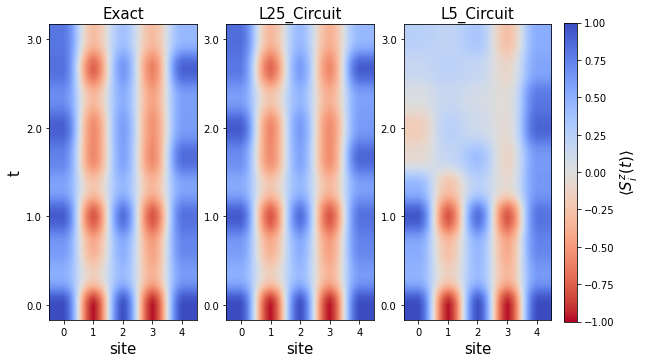

In [8]:
# 分别计算时长为 3 时，通过步长为 25、5 的电路得到的演化过程，以及精确解
z_obs_total_exact = get_evolution_z_obs(h, t_total=3, exact=True)
z_obs_total_cir = get_evolution_z_obs(h, order=1, n_steps=25, t_total=3)
z_obs_total_cir_short = get_evolution_z_obs(h, order=1, n_steps=5, t_total=3)

plot_comparison(
    Exact=z_obs_total_exact,
    L25_Circuit=z_obs_total_cir,
    L5_Circuit=z_obs_total_cir_short)

我们观察到当线路的深度为 25 时（注意这里的深度指的是时间块的数量而不是量子门的层数），量子电路可以较好的模拟系统在完整演化时间内的自旋动力学。若使用较浅的量子线路，则只能正确模拟系统的行为至一定的时间。

**思考：** 读者是否可以尝试来测量自旋空间关联函数 $\langle S_i^z S_j^{z} \rangle$ 并观察其随时间的变化？

## 设计基于随机置换的自定义时间演化电路

### 随机置换

尽管从物理的角度上看来，将哈密顿量中的对易项重新排列在一起来减小模拟误差是符合直觉的，但是许多证据都表明，固定一种哈密顿量排列的演化策略将会导致模拟误差不断地累积，反而不如将哈密顿量的排列顺序在每个“时间块”中都进行随机置换来得有效 [8, 9]。人们发现，通过不断地将哈密顿量的排列顺序进行随机置换，其演化过程中造成的随机误差比起固定排列时的累积误差来说更加“无害” [8]。无论是在理论上的误差上界与经验性的实验都表明，这种随机排列的演化策略比起固定排列的 Suzuki product formula 具有更小的误差 [9]。

### 搭建自定义时间演化电路

量桨中的 `construct_trotter_circuit()` 函数会默认根据 Suzuki product formula 以及输入哈密顿量的顺序来添加时间演化电路。同时，用户可以通过设置 `method='custom'` 并同时向参数 `permutation` 以及 `coefficient` 传入数组的方式来自定义时间演化策略。

**提醒：** 用户在使用 `coefficient`、`tau` 以及 `steps` 参数时需要小心它们之间的关系。一般情况下，传入 `coefficient` 的数组应当是归一化的，即它本身描述的是 $t=1$ 的时间演化过程。在这个基础上，通过设置更多的 `steps`，该函数会将传入的自定义参数所描述的时间演化策略作为一个基本的“时间块”并进行重复，其中每个时间块的演化时长由参数 `tau` 决定。举个例子，若设置 `permutation=np.arange(h.n_qubits)` 且 `coefficient=np.ones(h.n_qubits)`，此时通过 `tau` 与 `steps` 来定义的时间演化电路与一阶 product formula 电路是完全一致的。

让我们进一步实际展示一下该自定义功能：考虑和之前相同的哈密顿量，现在我们通过设计一个时间演化电路来测试上文提到的随机置换的结论，即我们希望搭建一个类似于一阶 product formula 的电路，只不过在每个”时间块“内的哈密顿量排列是完全随机且独立的。通过传入一个形状为 `(n_steps, h.n_terms)` 且其每一行都是一个随机置换 $P(N)$ 的数组至参数 `permutation`，就可以实现这一想法：

In [9]:
# 自定义 permutation 参数的一个例子
permutation = np.vstack([np.random.permutation(h.n_terms) for i in range(100)])

接下来，为了验证，可以分别计算该随机电路以及一阶 product formula 在不同电路深度下与精确解之间的保真度来进行比较：

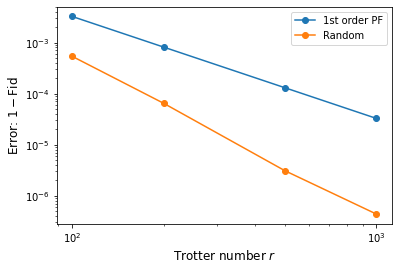

In [10]:
def compare(n_steps):
    """
    比较一阶 product formula 以及随机置换方法在同样的步长的情况下对于固定演化时长 t=2 时的保真度
    输入参数控制步长，输出分别为一阶 product formula 以及随机置换的保真度
    """
    t = 2
    cir_evolve = UAnsatz(5)
    construct_trotter_circuit(cir_evolve, h, tau=t/n_steps, steps=n_steps, order=1)
    U_cir = cir_evolve.U.numpy()
    fid_suzuki = gate_fidelity(get_evolve_op(t), U_cir)
    cir_permute = UAnsatz(5)
    permutation = np.vstack([np.random.permutation(h.n_terms) for i in range(n_steps)])
    # 当不指定 coefficient 参数时，会默认根据 permutation 的形状设置一个归一化且均匀的 coefficient
    construct_trotter_circuit(cir_permute, h, tau=t, steps=1, method='custom', permutation=permutation)
    U_cir = cir_permute.U.numpy()
    fid_random = gate_fidelity(get_evolve_op(t), U_cir)
    return fid_suzuki, fid_random

# 比较在不同步长时的两种方案的保真度
# 出于运行时间的考虑，只进行一次试验，感兴趣的读者可以进行多次重复实验并计算其 error bar
n_range = [100, 200, 500, 1000]
result = [compare(n) for n in n_range]

result = 1 - np.array(result)
plt.loglog(n_range, result[:, 0], 'o-', label='1st order PF')
plt.loglog(n_range, result[:, 1], 'o-', label='Random')
plt.xlabel(r'Trotter number $r$', fontsize=12)
plt.ylabel(r'Error: $1 - {\rm Fid}$', fontsize=12)
plt.legend()
plt.show()

图中，“1st order PF” 指按照固定顺序搭建的一阶 product formula 电路。与预期一样，随机置换确实可以在相同的电路深度下达到比一阶 product formula 更好的模拟效果。

**思考：** 在 [9] 中，作者指出这种随机的策略在没有利用任何与哈密顿量有关的信息的前提下就取得了更小的误差，那么有理由相信存在一种方法可以在利用哈密顿量信息的同时进一步减小该误差。这对于人们设计更好的模拟时间演化策略带来了启发。

## 小结

对于量子多体系统的动力学性质进行研究，是理解新奇量子物态的重要手段。由于其高度纠缠的量子力学本质，无论是在理论上还是在实验上的研究都是十分困难的。时至今日，人们对于不同几何结构，不同相互作用下的二维，乃至包含了无序性的一维系统上的物理现象都没能完全理解。另一方面，通用量子计算机以及量子模拟器的快速发展给这一问题的解决带来了新的希望。以通用量子计算机为例，通过搭建量子电路，其优势在于可以模拟各种复杂情况下的系统演化过程，例如，模拟其哈密顿量随时间周期性变化的系统从而寻找“时间晶体”的存在。随着量子比特数目和控制能力的进一步提高，通用量子计算机有望在近未来内在模拟量子系统时间演化这一任务上超越经典计算机，这其中，最有希望最先取得进展的就是量子自旋系统的模拟。

本教程主要介绍了如何在量桨中模拟一个真实量子自旋模型的时间演化过程，并且进一步探讨了基于量桨来设计新的时间演化策略的可能性。通过 `construct_trotter_circuit()` 函数以及 `Hamiltonian` 和 `SpinOps` 类中提供的各种方法，用户现在可以简单地设计并测试不同搭建时间演化的策略。我们也鼓励读者在更多的物理系统上尝试不同的时间演化策略，并一起探索更加高效的量子模拟电路。

---

## 参考文献

[1] Childs, Andrew M., et al. "Toward the first quantum simulation with quantum speedup." [Proceedings of the National Academy of Sciences 115.38 (2018): 9456-9461](https://www.pnas.org/content/115/38/9456.short).

[2] Eckle, Hans-Peter. Models of Quantum Matter: A First Course on Integrability and the Bethe Ansatz. [Oxford University Press, 2019](https://oxford.universitypressscholarship.com/view/10.1093/oso/9780199678839.001.0001/oso-9780199678839).

[3] Mikeska, Hans-Jürgen, and Alexei K. Kolezhuk. "One-dimensional magnetism." Quantum magnetism. Springer, Berlin, Heidelberg, 2004. 1-83.

[4] Berger, L., S. A. Friedberg, and J. T. Schriempf. "Magnetic Susceptibility of $\rm Cu(NO_3)_2·2.5 H_2O$ at Low Temperature." [Physical Review 132.3 (1963): 1057](https://journals.aps.org/pr/abstract/10.1103/PhysRev.132.1057).

[5] Broholm, C., et al. "Quantum spin liquids." [Science 367.6475 (2020)](https://science.sciencemag.org/content/367/6475/eaay0668).

[6] Abanin, Dmitry A., et al. "Colloquium: Many-body localization, thermalization, and entanglement." [Reviews of Modern Physics 91.2 (2019): 021001](https://journals.aps.org/rmp/abstract/10.1103/RevModPhys.91.021001).

[7] Medenjak, Marko, Berislav Buča, and Dieter Jaksch. "Isolated Heisenberg magnet as a quantum time crystal." [Physical Review B 102.4 (2020): 041117](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.102.041117).

[8] Wallman, Joel J., and Joseph Emerson. "Noise tailoring for scalable quantum computation via randomized compiling." [Physical Review A 94.5 (2016): 052325](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.94.052325).

[9] Childs, Andrew M., Aaron Ostrander, and Yuan Su. "Faster quantum simulation by randomization." [Quantum 3 (2019): 182](https://quantum-journal.org/papers/q-2019-09-02-182/).